In [94]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
import seaborn as sns
import glob
import os
import re
from scipy.signal import savgol_filter
from skimage.measure import profile_line
import matplotlib.patches as mpatches

In [111]:
def recursive_rastersstats_to_dict(path, fn_regex=r'*2018.tif'):
    """
    Recursively read all rasters in a certain directory and store arrays and
    metadata including statistics in a dicitonary. Filter rasters by suffix or other wildcard.

    Read all GeoTIFFs with rasterio and store values inside an numpy
    array while conserving some metadata inside a dictionary.

    Args:
        path (str): file path to directory containing rasters

    Returns:
        arr (ndarray): array of elevation values
        pixel_size (float): pixel size aka grid/spatial resolution
        profile (dict): metadata profile
    Raises:
        Exception: description
    """

    # Initialize empty dictionary
    rstr_dict = {}
    # Get rasters that in dir and all subdirs that match pattern
    for f in glob.iglob(os.path.join(path, '**', fn_regex), recursive=True):
        
        kf = f.split('/')[-1][:-4]
        if 'v.' in kf:
            kf = kf.split('_')[-2].upper()
        elif 'depth' in kf:
            kf = kf.split('_')[-1] + ' Depth [m]'
        rstr_dict[kf] = {}

        src = rasterio.open(f)
        arr = src.read(1)
        mask = (arr < 0)
        new_array = np.copy(arr)
        arrb = arr + 0.15
        new_array[mask] = arrb[mask]
        rstr_dict[kf]['arr'] = new_array        
        rstr_dict[kf]['mu'] = np.nanmean(rstr_dict[kf]['arr'])
        rstr_dict[kf]['sigma'] = np.nanstd(rstr_dict[kf]['arr'])
        rstr_dict[kf]['CV'] = rstr_dict[kf]['sigma'] / rstr_dict[kf]['mu']
        rstr_dict[kf]['profile'] = src.profile
        rstr_dict[kf]['year'] = re.findall('(\d{4})', f)

    return rstr_dict


In [112]:
clpx_lake = recursive_rastersstats_to_dict('../../../similarity_results/clpx_lake_e/', r'*.tif')

sub = {}

interesting_keys = ['2012 Depth', '2016 Depth', 'dem','NRMSE','SSIM', 'CW-SSIM', 'GMS']
for k in interesting_keys:
    for dk in clpx_lake.keys():
        if k in dk:
            sub[dk]=clpx_lake[dk]
            
del clpx_lake
sub.keys()

dict_keys(['2012 Depth [m]', '2016 Depth [m]', 'clpx_lake_e_dem', 'NRMSE', 'CWSSIM', 'SSIM', 'GMS'])

In [113]:
len(sub)

7

In [114]:
clpx_lake_dem = sub.pop('clpx_lake_e_dem')
print(clpx_lake_dem['arr'].shape)

(450, 670)


In [115]:
len(sub)

6

In [116]:
# row, col
oblique_src = (420, 640)
oblique_dst = (310, 510)
north_src = (420, 640)
north_dst = (30, 640)

391
172


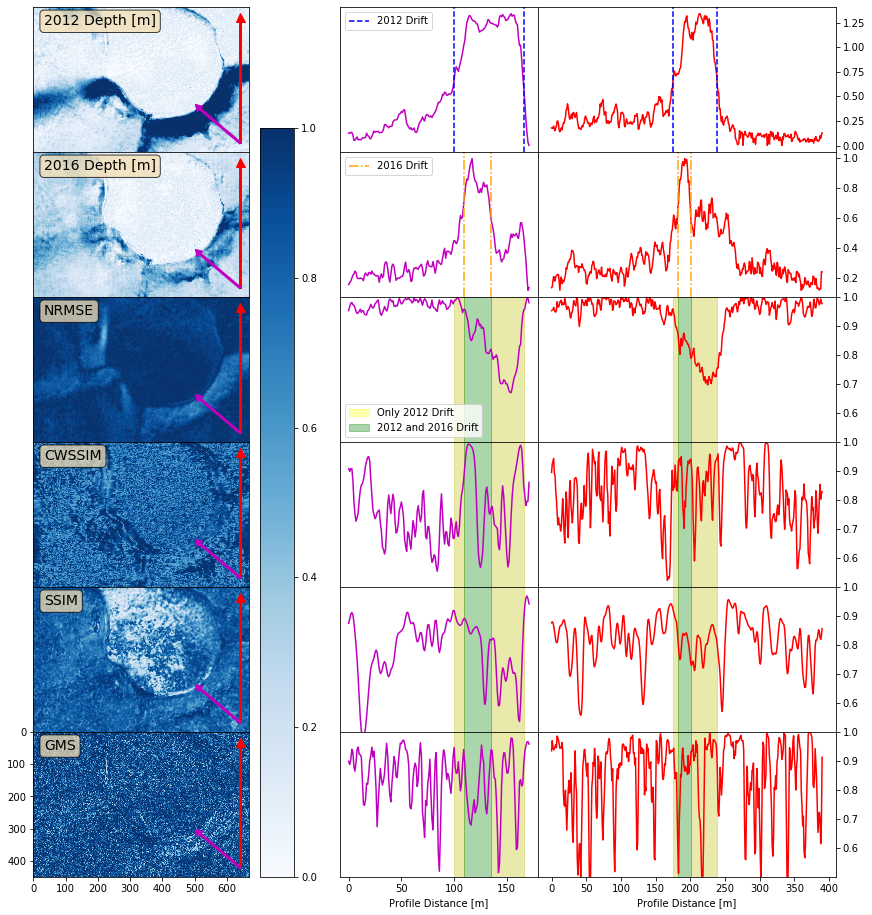

In [117]:
f, axes = plt.subplots(6, 3, gridspec_kw = {'width_ratios':[1, 0.5, 0.75]}, figsize=(16,16))
i = 0

for k in sub.keys():

    # Plot the snow depth and IQA Arrays with annotations
    im = axes[i][0].imshow(sub[k]['arr'], vmin=0, vmax=1, cmap='Blues')
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.75)
    axes[i][0].text(0.05, 0.95, k, transform=axes[i][0].transAxes,
                    fontsize=14, verticalalignment='top', bbox=props)

    # Plot the two transect lines over top each array
    oblique_line = profile_line(sub[k]['arr'], oblique_src, oblique_dst)
    north_line = profile_line(sub[k]['arr'], north_src, north_dst)
    
    axes[i][0].plot((north_src[1], north_dst[1]),
                    (north_src[0], north_dst[0]),
                    color='r', lw=3)
    axes[i][0].plot((oblique_src[1], oblique_dst[1]),
                    (oblique_src[0], oblique_dst[0]),
                    color='m', lw=3)
    axes[i][0].plot(oblique_dst[1], oblique_dst[0],
                    color='m', marker=(3,0,45), markersize=9)
    axes[i][0].plot(north_dst[1], north_dst[0],
                    color='r', marker='^', markersize=9)
    
    # Isolate drift chunks using 0.65 m threshold
    if i == 0:
        n12sup_thresh_indices = [idx for idx in range(len(north_line)) if north_line[idx] > 0.65]
        n12sub_thresh_indices = [idx for idx in range(len(north_line)) if north_line[idx] <= 0.65]
        north_drift_start_12 = n12sup_thresh_indices[0]
        north_drift_end_12 = [x for x in n12sub_thresh_indices if x > north_drift_start_12][0]
        #print(north_drift_start_12)
        #print(north_drift_end_12)
        print(len(north_line))
        print(len(oblique_line))
        
        
        o12sup_thresh_indices = [idx for idx in range(len(oblique_line)) if oblique_line[idx] > 0.65]
        o12sub_thresh_indices = [idx for idx in range(len(oblique_line)) if oblique_line[idx] <= 0.65]
        oblique_drift_start_12 = o12sup_thresh_indices[0]
        oblique_drift_end_12 = [x for x in o12sub_thresh_indices if x > oblique_drift_start_12][0]
        #print(oblique_drift_start_12)
        #print(oblique_drift_end_12)
        
    if i == 1:
        n16sup_thresh_indices = [idx for idx in range(len(north_line)) if north_line[idx] > 0.65]
        n16sub_thresh_indices = [idx for idx in range(len(north_line)) if north_line[idx] <= 0.65]
        north_drift_start_16 = n16sup_thresh_indices[0]
        north_drift_end_16 = [x for x in n16sub_thresh_indices if x > north_drift_start_16][0]
        #print(north_drift_start_16)
        #print(north_drift_end_16)
        
        o16sup_thresh_indices = [idx for idx in range(len(oblique_line)) if oblique_line[idx] > 0.65]
        o16sub_thresh_indices = [idx for idx in range(len(oblique_line)) if oblique_line[idx] <= 0.65]
        oblique_drift_start_16 = o16sup_thresh_indices[0]
        oblique_drift_end_16 = [x for x in o16sub_thresh_indices if x > oblique_drift_start_16][0]
        #print(oblique_drift_start_16)
        #print(oblique_drift_end_16)
        
    if i != 5:
        axes[i][0].get_shared_x_axes().join(axes[5][0], axes[i][0])
        axes[i][0].set_yticks([])
        axes[i][0].set_xticks([])
        axes[i][1].get_shared_x_axes().join(axes[5][1], axes[i][1])
        axes[i][1].set_xticks([])
        axes[i][2].get_shared_x_axes().join(axes[5][2], axes[i][2])
        axes[i][2].set_xticks([])
    
    if i > 2:
        axes[i][1].plot(savgol_filter(oblique_line, 3, 1), color='m')
        axes[i][2].plot(savgol_filter(north_line, 3, 1), color='r')
        axes[i][1].yaxis.tick_right()
        axes[i][2].yaxis.tick_right()
    else:
        axes[i][1].plot(oblique_line, color='m')
        axes[i][2].plot(north_line, color='r')
        axes[i][1].yaxis.tick_right()
        axes[i][2].yaxis.tick_right()
    
    if i > 1:
        axes[i][1].set_ylim([0.5, 1.0])
        axes[i][2].set_ylim([0.5, 1.0])
        axes[i][2].set_yticks([0.6, 0.7, 0.8, 0.9, 1.0])
        axes[i][1].axvspan(oblique_drift_start_12, oblique_drift_start_16, alpha=0.33, color='y')
        axes[i][1].axvspan(oblique_drift_end_12, oblique_drift_end_16, alpha=0.33, color='y')
        axes[i][1].axvspan(oblique_drift_start_16, oblique_drift_end_16, alpha=0.33, color='green')
        axes[i][2].axvspan(north_drift_start_12, north_drift_start_16, alpha=0.33, color='y')
        axes[i][2].axvspan(north_drift_end_12, north_drift_end_16, alpha=0.33, color='y')
        axes[i][2].axvspan(north_drift_start_16, north_drift_end_16, alpha=0.33, color='green')
        
        
        
    if i == 5:
        axes[i][1].set_xlabel('Profile Distance [m]')
        axes[i][2].set_xlabel('Profile Distance [m]')
        
    
    
    
    axes[i][1].get_shared_y_axes().join(axes[i][2], axes[i][1])
    axes[i][1].set_yticks([])
    
    i+=1

axes[0][1].axvline(x=oblique_drift_start_12, color='blue', ls='--',
                  label='2012 Drift') 
axes[0][1].axvline(x=oblique_drift_end_12, color='blue', ls='--')
axes[0][2].axvline(x=north_drift_start_12, color='blue', ls='--') 
axes[0][2].axvline(x=north_drift_end_12, color='blue', ls='--')

axes[1][1].axvline(x=oblique_drift_start_16, color='orange', ls='-.',
                  label='2016 Drift') 
axes[1][1].axvline(x=oblique_drift_end_16, color='orange', ls='-.')
axes[1][2].axvline(x=north_drift_start_16, color='orange', ls='-.') 
axes[1][2].axvline(x=north_drift_end_16, color='orange', ls='-.')
axes[0][1].legend()
axes[1][1].legend()

g_patch = mpatches.Patch(color='green', alpha=0.33, label='2012 and 2016 Drift')
y_patch = mpatches.Patch(color='yellow', alpha=0.33, label='Only 2012 Drift')

axes[2][1].legend(handles=[y_patch, g_patch])

f.subplots_adjust(hspace=0, wspace=0)

cbar_ax = f.add_axes([0.4, 0.125, 0.03, 0.65])
f.colorbar(im, cax=cbar_ax, orientation='vertical')
# f.suptitle('CLPX Outcrops 2012 vs. 2018: Snow Depth Pattern Similarity Maps and Surface Profiles',
#            size=16, y=0.91)

plt.savefig('../../figs/pngs/drift_scour_fidelity_fig.png', dpi=200, bbox_inches='tight')



In [67]:
391/670

0.5835820895522388

In [68]:
172 / 670
# ax.axes.annotate('gms min', xy=ind_frac,  xycoords='axes fraction',
#             xytext=ind_frac_text, textcoords='axes fraction',
#             arrowprops=dict(facecolor='red', shrink=0.05),
#             horizontalalignment='right', verticalalignment='top',
#             );


0.25671641791044775

In [148]:
hv = recursive_rastersstats_to_dict('../../../similarity_results/hv_watertrack//', r'*.tif')

sub = {}

interesting_keys = ['2012 Depth', '2017 Depth', 'dem','NRMSE','SSIM', 'CW-SSIM', 'GMS']
for k in interesting_keys:
    for dk in hv.keys():
        if k in dk:
            sub[dk]=hv[dk]
            
del hv
sub.keys()

dict_keys(['2012 Depth [m]', '2017 Depth [m]', 'hv_watertrack_dem', 'NRMSE', 'SSIM', 'CWSSIM', 'GMS'])

In [149]:
hv_dem = sub.pop('hv_watertrack_dem')
print(hv_dem['arr'].shape)

(500, 900)


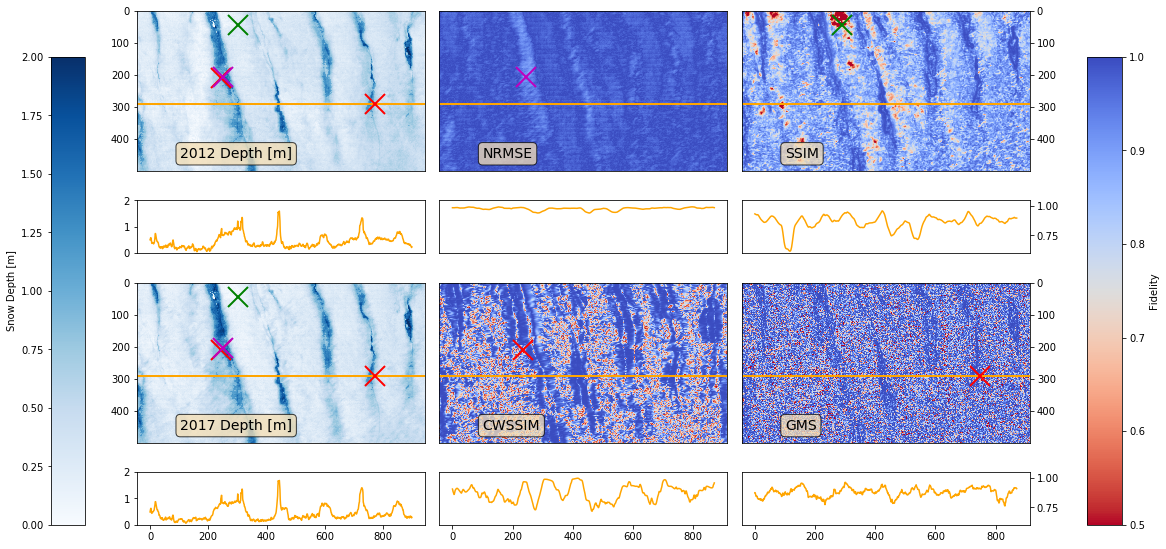

In [275]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(16, 10))

gs = GridSpec(4, 3, width_ratios=[1, 1, 1], height_ratios=[5,1.2,5,1.2])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax5 = fig.add_subplot(gs[4])
ax6 = fig.add_subplot(gs[5])
ax7 = fig.add_subplot(gs[6])
ax8 = fig.add_subplot(gs[7])
ax9 = fig.add_subplot(gs[8])
ax10 = fig.add_subplot(gs[9])
ax11 = fig.add_subplot(gs[10])
ax12 = fig.add_subplot(gs[11])

bigs = [ax1,ax2,ax3,
        ax7,ax8,ax9]
littles = [ax4,ax5,ax6,
           ax10,ax11,ax12]
tops = [ax1,ax2,ax3,
        ax4,ax5,ax6,
        ax7,ax8,ax9]

middles = [ax2,ax5,ax8,ax11]
rights = [ax3,ax6,ax9,ax12]

for ax in tops:
    ax.set_xticks([])
for ax in middles:
    ax.set_yticks([])
for ax in rights:
    ax.yaxis.tick_right()

props = dict(boxstyle='round', facecolor='wheat', alpha=0.75)
im1 = ax1.imshow(sub['2012 Depth [m]']['arr'], vmin=0,vmax=2,cmap='Blues')
ax7.imshow(sub['2017 Depth [m]']['arr'], vmin=0,vmax=2,cmap='Blues')
im2 = ax2.imshow(sub['NRMSE']['arr'], vmin=0.5, vmax=1, cmap='coolwarm_r')
ax3.imshow(sub['SSIM']['arr'], vmin=0.5, vmax=1, cmap='coolwarm_r')
ax8.imshow(sub['CWSSIM']['arr'], vmin=0.5, vmax=1, cmap='coolwarm_r')
ax9.imshow(sub['GMS']['arr'], vmin=0.5, vmax=1, cmap='coolwarm_r')


pinklines = []
orangelines = []
for ax in bigs:
    ax.axhline(y=290, color='orange', lw=2)
    #ax.axhline(y=30, color='m', lw=2)
    pinklines.append(ax.images[0].get_array()[30])
    orangelines.append(ax.images[0].get_array()[290])

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

for ax in littles:
    ax.set_ylim([0.6, 1.05])
ax4.set_ylim([0, 2])
ax4.plot(orangelines[0], color='orange')
ax5.plot(running_mean(orangelines[1], 30), color='orange')
ax6.plot(running_mean(orangelines[2], 30), color='orange')

ax10.set_ylim([0, 2])
ax10.plot(orangelines[3], color='orange')
ax11.plot(running_mean(orangelines[4],30), color='orange')
ax12.plot(running_mean(orangelines[5],30), color='orange')


min_ssimx, min_ssimy = find_min_idx(sub['SSIM']['arr'])
min_cwssimx, min_cwssimy = find_min_idx(sub['CWSSIM']['arr'])
min_gmsx, min_gmsy = find_min_idx(sub['GMS']['arr'])
min_nrmsex, min_nrmsey = find_min_idx(sub['NRMSE']['arr'])


ax8.plot(min_cwssimy, min_cwssimx, marker='x', markeredgecolor='r',
         markerfacecolor='none', markeredgewidth=2, ms=20)
ax1.plot(min_cwssimy, min_cwssimx, marker='x', markeredgecolor='r',
         markerfacecolor='none', markeredgewidth=2, ms=20)
ax7.plot(min_cwssimy, min_cwssimx, marker='x', markeredgecolor='r',
         markerfacecolor='none', markeredgewidth=2, ms=20)

ax3.plot(min_ssimy, min_ssimx, marker='x', markeredgecolor='green',
         markerfacecolor='none', markeredgewidth=2, ms=20)
ax1.plot(min_ssimy, min_ssimx, marker='x', markeredgecolor='green',
         markerfacecolor='none', markeredgewidth=2, ms=20)
ax7.plot(min_ssimy, min_ssimx, marker='x', markeredgecolor='green',
         markerfacecolor='none', markeredgewidth=2, ms=20)


ax1.plot(min_nrmsey, min_nrmsex, marker='x', markeredgecolor='m',
         markerfacecolor='none', markeredgewidth=2, ms=20)
ax2.plot(min_nrmsey, min_nrmsex, marker='x', markeredgecolor='m',
         markerfacecolor='none', markeredgewidth=2, ms=20)
ax7.plot(min_nrmsey, min_nrmsex, marker='x', markeredgecolor='m',
         markerfacecolor='none', markeredgewidth=2, ms=20)

ax1.plot(min_gmsy, min_gmsx, marker='x', markeredgecolor='r',
         markerfacecolor='none', markeredgewidth=2, ms=20)
ax7.plot(min_gmsy, min_gmsx, marker='x', markeredgecolor='r',
         markerfacecolor='none', markeredgewidth=2, ms=20)
ax9.plot(min_gmsy, min_gmsx, marker='x', markeredgecolor='r',
         markerfacecolor='none', markeredgewidth=2, ms=20)

titles = ['2012 Depth [m]', 'NRMSE', 'SSIM', '2017 Depth [m]', 'CWSSIM', 'GMS']
for i in zip(bigs, titles):
    i[0].text(0.15, 0.15, i[1], transform=i[0].transAxes,
              fontsize=14, verticalalignment='top', bbox=props)
    

cbar_ax = fig.add_axes([0.05, 0.125, 0.03, 0.65])
fig.colorbar(im1, cax=cbar_ax, orientation='vertical', label='Snow Depth [m]')
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('left')

cbar_ax2 = fig.add_axes([0.95, 0.125, 0.03, 0.65])
fig.colorbar(im2, cax=cbar_ax2, orientation='vertical', label='Fidelity')    

fig.subplots_adjust(hspace=0.0001, wspace=0.05)

plt.savefig('../../figs/pngs/hv_water_track_2012_2017_drift_scour_fidelity_fig.png',
            dpi=200, bbox_inches='tight')


In [213]:
np.argmin(sub['2012 Depth [m]']['arr'])

29037

In [230]:
def find_min_idx(x):
    k = x.argmin()
    ncol = x.shape[1]
    return int(k/ncol), int(k%ncol)

In [231]:
find_min_idx(sub['2012 Depth [m]']['arr'])

(32, 237)

In [232]:
find_min_idx(sub['SSIM']['arr'])

(43, 314)

In [233]:
find_min_idx(sub['CWSSIM']['arr'])

(211, 262)

In [241]:
find_min_idx(sub['GMS']['arr'])

(291, 743)

In [242]:
sub['2012 Depth [m]']['arr'].shape

(500, 900)